## Get totally lost on this lab. Try to figure out a way. Look at the labs from others, but get really stuck at the end. 
## Sorry. Hope we discuss this lab in class. 

In [ ]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

password = getpass.getpass()

## 1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.

In [204]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''
        SELECT f.film_id, c.name AS category, release_year, language_id, rental_duration, rental_rate, length, replacement_cost, rating
        FROM film f
        JOIN film_category fc
        ON fc.film_id = f.film_id
        JOIN category c
        ON c.category_id = fc.category_id;
        '''

## 2. Read the data into a Pandas dataframe

In [205]:
data = pd.read_sql_query(query, engine)
data

,film_id,category,release_year,language_id,rental_duration,rental_rate,length,replacement_cost,rating
0,19,Action,2006,1,6,0.99,113,20.99,PG
1,21,Action,2006,1,3,4.99,129,17.99,R
2,29,Action,2006,1,5,2.99,168,11.99,NC-17
3,38,Action,2006,1,6,0.99,68,25.99,NC-17
4,56,Action,2006,1,6,2.99,129,15.99,G
...,...,...,...,...,...,...,...,...,...
995,931,Travel,2006,1,7,0.99,48,9.99,PG-13
996,977,Travel,2006,1,3,2.99,85,25.99,R
997,981,Travel,2006,1,7,0.99,55,13.99,NC-17
998,988,Travel,2006,1,7,2.99,139,26.99,R


## 3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [206]:
data.shape

(1000, 9)

In [207]:
data.describe()

,film_id,release_year,language_id,rental_duration,rental_rate,length,replacement_cost
count,1000.000000,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,2006.0,1.0,4.985000,2.980000,115.272000,19.984000
std,288.819436,0.0,0.0,1.411654,1.646393,40.426332,6.050833
min,1.000000,2006.0,1.0,3.000000,0.990000,46.000000,9.990000
25%,250.750000,2006.0,1.0,4.000000,0.990000,80.000000,14.990000
50%,500.500000,2006.0,1.0,5.000000,2.990000,114.000000,19.990000
75%,750.250000,2006.0,1.0,6.000000,4.990000,149.250000,24.990000
max,1000.000000,2006.0,1.0,7.000000,4.990000,185.000000,29.990000


In [208]:
data.isnull().sum()

film_id             0
category            0
release_year        0
language_id         0
rental_duration     0
rental_rate         0
length              0
replacement_cost    0
rating              0
dtype: int64

In [209]:
data = data.dropna()

In [210]:
data.dtypes

film_id               int64
category             object
release_year          int64
language_id           int64
rental_duration       int64
rental_rate         float64
length                int64
replacement_cost    float64
rating               object
dtype: object

In [211]:
data = data.set_index('film_id')
data

,category,release_year,language_id,rental_duration,rental_rate,length,replacement_cost,rating
film_id,,,,,,,,
19,Action,2006,1,6,0.99,113,20.99,PG
21,Action,2006,1,3,4.99,129,17.99,R
29,Action,2006,1,5,2.99,168,11.99,NC-17
38,Action,2006,1,6,0.99,68,25.99,NC-17
56,Action,2006,1,6,2.99,129,15.99,G
...,...,...,...,...,...,...,...,...
931,Travel,2006,1,7,0.99,48,9.99,PG-13
977,Travel,2006,1,3,2.99,85,25.99,R
981,Travel,2006,1,7,0.99,55,13.99,NC-17


In [213]:
data = data.drop(['release_year', 'language_id'], axis=1)

In [214]:
data['rental_duration'] = data['rental_duration'].astype('object')
data['rental_rate'] = data['rental_rate'].astype('object')

### EDA

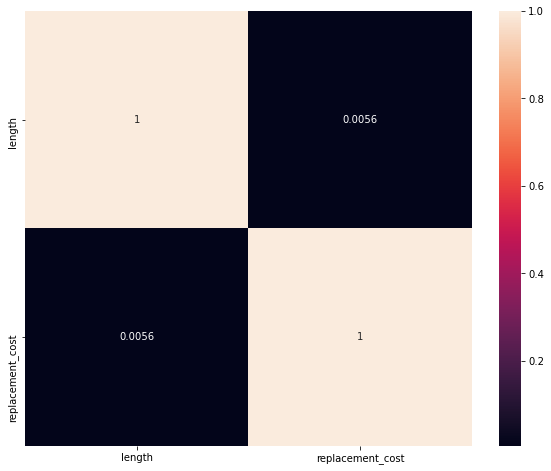

In [215]:
corr_matrix=data.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

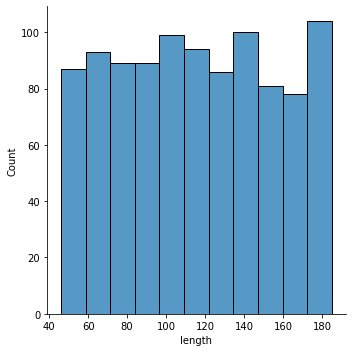

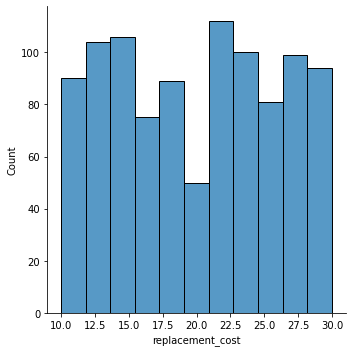

In [216]:
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()

In [217]:
df = pd.get_dummies(data, drop_first=True)
df

,length,replacement_cost,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,category_Foreign,...,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rental_rate_2.99,rental_rate_4.99,rating_NC-17,rating_PG,rating_PG-13,rating_R
film_id,,,,,,,,,,,,,,,,,,,,,
19,113,20.99,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
21,129,17.99,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
29,168,11.99,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
38,68,25.99,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
56,129,15.99,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,48,9.99,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
977,85,25.99,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
981,55,13.99,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [219]:
for col in df.select_dtypes(np.number):
    print(df[col].value_counts(), '\n')

85     17
84     13
112    13
179    13
73     12
       ..
81      3
55      2
95      2
96      2
66      2
Name: length, Length: 140, dtype: int64 

20.99    57
21.99    55
12.99    55
22.99    55
13.99    55
29.99    53
27.99    53
14.99    51
19.99    50
10.99    49
11.99    49
17.99    47
26.99    46
23.99    45
25.99    43
18.99    42
9.99     41
28.99    41
16.99    38
24.99    38
15.99    37
Name: replacement_cost, dtype: int64 

0    934
1     66
Name: category_Animation, dtype: int64 

0    940
1     60
Name: category_Children, dtype: int64 

0    943
1     57
Name: category_Classics, dtype: int64 

0    942
1     58
Name: category_Comedy, dtype: int64 

0    932
1     68
Name: category_Documentary, dtype: int64 

0    938
1     62
Name: category_Drama, dtype: int64 

0    931
1     69
Name: category_Family, dtype: int64 

0    927
1     73
Name: category_Foreign, dtype: int64 

0    939
1     61
Name: category_Games, dtype: int64 

0    944
1     56
Name: category_Horror, d

## 4. Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

In [157]:
query_rented = '''
USE sakila; 

CREATE OR REPLACE VIEW  rented_films AS
SELECT *
FROM rental r
JOIN inventory i
ON i.inventory_id = r.inventory_id;

CREATE OR REPLACE VIEW  rented_films_1 AS
SELECT DATE_FORMAT(CONVERT(r.rental_date, DATE), '%Y-%m') AS new_rental_date,
i.film_id
FROM rental r
JOIN inventory i
ON i.inventory_id = r.inventory_id; 

CREATE OR REPLACE VIEW  rented_films_2 AS
SELECT new_rental_date, film_id,
RANK() OVER(PARTITION BY film_id ORDER BY new_rental_date DESC) AS ranking
FROM rented_films_1; 

CREATE OR REPLACE VIEW  rented_films_3 AS
SELECT * FROM rented_films_2
WHERE ranking = 1
AND new_rental_date = (SELECT MAX(new_rental_date) AS last_month FROM rented_films_1);


CREATE OR REPLACE VIEW  rented_films_y AS
SELECT f.film_id, re.new_rental_date
FROM film f
LEFT JOIN rented_films_3 re
ON re.film_id = f.film_id;
        '''

## 5. Create a logistic regression model to predict this variable from the cleaned data.

In [220]:
X = data
X

,category,rental_duration,rental_rate,length,replacement_cost,rating
film_id,,,,,,
19,Action,6,0.99,113,20.99,PG
21,Action,3,4.99,129,17.99,R
29,Action,5,2.99,168,11.99,NC-17
38,Action,6,0.99,68,25.99,NC-17
56,Action,6,2.99,129,15.99,G
...,...,...,...,...,...,...
931,Travel,7,0.99,48,9.99,PG-13
977,Travel,3,2.99,85,25.99,R
981,Travel,7,0.99,55,13.99,NC-17


In [237]:
X = pd.get_dummies(X)
X

,length,replacement_cost,category_Action,category_Animation,category_Children,category_Classics,category_Comedy,category_Documentary,category_Drama,category_Family,...,rental_duration_6,rental_duration_7,rental_rate_0.99,rental_rate_2.99,rental_rate_4.99,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
film_id,,,,,,,,,,,,,,,,,,,,,
19,113,20.99,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
21,129,17.99,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
29,168,11.99,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
38,68,25.99,1,0,0,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
56,129,15.99,1,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
931,48,9.99,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
977,85,25.99,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
981,55,13.99,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0


In [238]:
y = pd.read_sql_table('rented_films_1', engine)
y

,new_rental_date,film_id
0,2005-05,80
1,2005-05,333
2,2005-05,373
3,2005-05,535
4,2005-05,450
...,...,...
16040,2006-02,977
16041,2006-02,982
16042,2006-02,990
16043,2006-02,998


In [239]:
y = y.set_index('film_id')
y

,new_rental_date
film_id,
80,2005-05
333,2005-05
373,2005-05
535,2005-05
450,2005-05
...,...
977,2006-02
982,2006-02
990,2006-02


In [232]:
y.isna().sum()

new_rental_date    0
dtype: int64

In [242]:
def showing_rented(x):
    if x == None:
        return 0
    else:
        return 1
    
y.new_rental_date.apply(showing_rented)

film_id
80     1
333    1
373    1
535    1
450    1
      ..
977    1
982    1
990    1
998    1
2      1
Name: new_rental_date, Length: 16045, dtype: int64

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

ValueError: Found input variables with inconsistent numbers of samples: [1000, 16045]

In [234]:
classification = LogisticRegression(random_state=42, max_iter=500) 
classification.fit(X_train, y_train)

ValueError: Unknown label type: 'unknown'

In [ ]:
predictions = classification.predict(X_test)
pd.Series(predictions).value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
confusion_matrix(y_test, predictions)

In [ ]:
confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.show()